In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last_expr"

In [2]:
%matplotlib inline
import sys
import csv
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from numpy import sqrt, cos, sin, pi
from numpy.fft import rfft, irfft
from tqdm import tqdm

print(tf.__version__)

2.2.0


- 1d closure ([Hammett & Perkins 1990 PRL](https://w3.pppl.gov/~hammett/refs/1990/Hammett_90_PRL_Landau_fluid_corrected.pdf))
$$\tilde{q}_{k}=-n_{0}\chi_{1}\frac{\sqrt{2}v_{t}}{\left|k\right|}ik\tilde{T}_{k}$$
where $\tilde{T}=\left(\tilde{p}-T_{0}\tilde{n}\right)/n_{0}$ and $\chi_{1}=\frac{2}{\sqrt{\pi}}$

In [3]:
nsamples_train = 10000
nsamples_valid = 1000
nsamples = nsamples_train + nsamples_valid

In [4]:
# physics parameters that define the input (feature) and output (label)
n0 = 1.
vt = 1.
chi1 = 2. / sqrt(pi)

lx = 2. * pi
nx = 128
kmax = 8

In [5]:
def make_modes(x, kmax, magnitude=1.):
    """Make many sinusoidal modes with random amplitudes and phases.

    Args:
        x: 1d spatial coordinates.
        kmax: k = 1, 2, ..., kmax.

    Returns:
        modes: Superposition of all modes.
    """
    A = np.random.random((kmax)) * magnitude
    phi = np.random.random((kmax)) * pi * 2
    modes = np.zeros_like(x)
    for k in range(1, kmax):
        A_k = A[k]
        phi_k = phi[k]
        modes += A_k * np.cos(k * x + phi_k)
    return modes


def make_training_data():
    x = np.linspace(0, lx, nx, dtype='f4')
    # using only zero and positive k since we will use rfft/irrf not fft/ifft
    k = np.arange(0, nx // 2 + 1, dtype='f4') * 2 * pi / lx

    T_all = []
    q_all = []

    kabs = abs(k)
    kabs[0] = np.finfo(np.float64).eps
    coeff_q = -1j * sqrt(2) * n0 * chi1 * vt * k / kabs

    for isample in tqdm(range(nsamples)):
        # Temperature flucutations in real space, T(x)
        T = make_modes(x, kmax)
        # Temperature fluctuations in Fourier spacer, T(k)
        Tk = rfft(T)
        # heatflux fluctuation in Fourier space, q(k)
        qk = coeff_q * Tk
        # heatflux fluctuation in real space, q(x)
        q = irfft(qk)

        # append real-space input/output of this sample
        T_all.append(T)
        q_all.append(q)

    # convert to ndarray of shape (nsamples, nx)
    T_all = np.array(T_all)
    q_all = np.array(q_all)

    return T_all, q_all


def normalize(arr):
    # all data have mean=0
    # XXX use the same max
    return arr / abs(arr).max()

In [6]:
T, q = make_training_data()

100%|██████████| 11000/11000 [00:00<00:00, 11461.35it/s]


In [7]:
T = normalize(T)
q = normalize(q)

In [8]:
train_data = T[:nsamples_train, ...]
train_labels = q[:nsamples_train, ...]

valid_data = T[nsamples_train:, ...]
valid_labels = q[nsamples_train:, ...]

In [9]:
num_nodes = 256
model = keras.Sequential([
    layers.Dense(num_nodes,
                 activation='relu',
                 input_shape=(train_data.shape[1], )),
    layers.Dense(num_nodes,
                 activation='relu'),
    layers.Dense(train_labels.shape[1],
                 activation='linear')
])

model.compile(loss='mse',
              optimizer=keras.optimizers.Adam(),
              metrics=['mae', 'mse'])

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               33024     
_________________________________________________________________
dense_1 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32896     
Total params: 131,712
Trainable params: 131,712
Non-trainable params: 0
_________________________________________________________________


In [11]:
# Train the model

# How many times we go through the entire dataset
EPOCHS = 500


# https://keras.io/guides/writing_your_own_callbacks/
class PrintLogs(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0:
            log_epoch = [
                '{} {:.2e}'.format(key, logs[key]) for key in logs.keys()
            ]
            print('EPOCH {}:'.format(epoch), '; '.join(log_epoch))


callbacks = [
    PrintLogs(),
]

# https://keras.io/api/models/model_training_apis/#fit-method
history = model.fit(train_data,
                    train_labels,
                    epochs=EPOCHS,
                    verbose=0,
                    callbacks=callbacks)

EPOCH 0: loss 4.35e-03; mae 3.70e-02; mse 4.35e-03
EPOCH 100: loss 4.40e-05; mae 4.86e-03; mse 4.40e-05
EPOCH 200: loss 1.38e-05; mae 2.81e-03; mse 1.38e-05
EPOCH 300: loss 1.36e-05; mae 2.59e-03; mse 1.36e-05
EPOCH 400: loss 8.93e-06; mae 2.16e-03; mse 8.93e-06


In [12]:
# Use the stats stored in the history object.
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mae,mse,epoch
495,0.000005,0.001777,0.000005,495
496,0.000010,0.002394,0.000010,496
497,0.000008,0.002116,0.000008,497
498,0.000007,0.001978,0.000007,498
499,0.000007,0.001985,0.000007,499


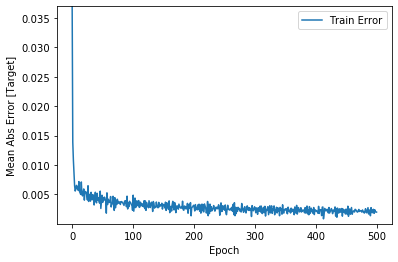

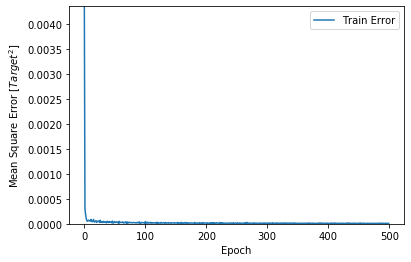

In [13]:
def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error [Target]')
    plt.plot(hist['epoch'], hist['mae'],
             label='Train Error')
#    plt.plot(hist['epoch'], hist['val_mae'],
#             label = 'Val Error')
    plt.legend()
    plt.ylim([min(hist['mse']) ,max(hist['mae'])])

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Square Error [$Target^2$]')
    plt.plot(hist['epoch'], hist['mse'],
             label='Train Error')
#    plt.plot(hist['epoch'], hist['val_mse'],
#             label = 'Val Error')
    plt.legend()
    plt.ylim([0,max(hist['mse'])])

plot_history(history)

In [14]:
# Compute the overall scores of the model
loss, mae, mse = model.evaluate(valid_data, valid_labels, verbose=1)
print("Testing set Mean Abs Error: {} ".format(mae))

32/32 [==============================] - 0s 3ms/step - loss: 2.8483e-05 - mae: 0.0041 - mse: 2.8483e-05
Testing set Mean Abs Error: 0.004063527099788189 


In [15]:
valid_predictions = model.predict(valid_data)

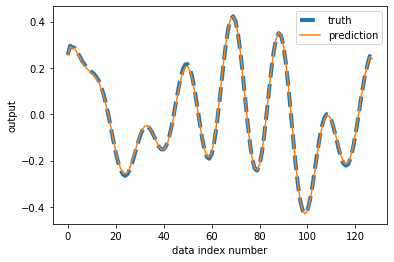

In [16]:
# compare truth and prediction for one or more samples
for isample in range(1):
    plt.figure()
    plt.plot(valid_labels[isample, :], lw=4, ls='--', label='truth')
    plt.plot(valid_predictions[isample, :], label='prediction')
    plt.legend()
    plt.xlabel('data index number')
    plt.ylabel('output')

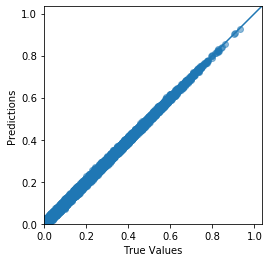

In [17]:
# do the 45-degree plot; close to the diagonal == good
plt.scatter(valid_labels, valid_predictions, alpha=0.5)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.axis('equal')
plt.axis('square')
plt.xlim([0, plt.xlim()[1]])
plt.ylim([0, plt.ylim()[1]])
plt.plot([-100, 100], [-100, 100])